In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sbn
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline

from Constants import *

In [2]:
seed = 8
np.random.seed(seed)

In [3]:
dataset = pd.read_csv(DATASET)
dataset.head(2)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2


In [4]:
dataset = dataset.drop("dataset",  axis = 1)
dataset = dataset.drop( "id",  axis = 1)
dataset.rename({'num' : 'target'}, axis = 'columns', inplace = True)

In [5]:
data = dataset.copy()

In [6]:
data.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0


In [7]:
data.shape

(920, 14)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        309 non-null    float64
 12  thal      434 non-null    object 
 13  target    920 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 100.8+ KB


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,920.0,53.510870,9.424685,28.0,47.0,54.0,60.0,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.0,130.0,140.0,200.0
chol,890.0,199.130337,110.780810,0.0,175.0,223.0,268.0,603.0
thalch,865.0,137.545665,25.926276,60.0,120.0,140.0,157.0,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.0,0.5,1.5,6.2
ca,309.0,0.676375,0.935653,0.0,0.0,0.0,1.0,3.0
target,920.0,0.995652,1.142693,0.0,0.0,1.0,2.0,4.0


In [10]:
data.mode()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,54,Male,asymptomatic,120.0,0.0,False,normal,150.0,False,0.0,flat,0.0,normal,0


In [11]:
# Handling null values

data.isnull().sum()

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

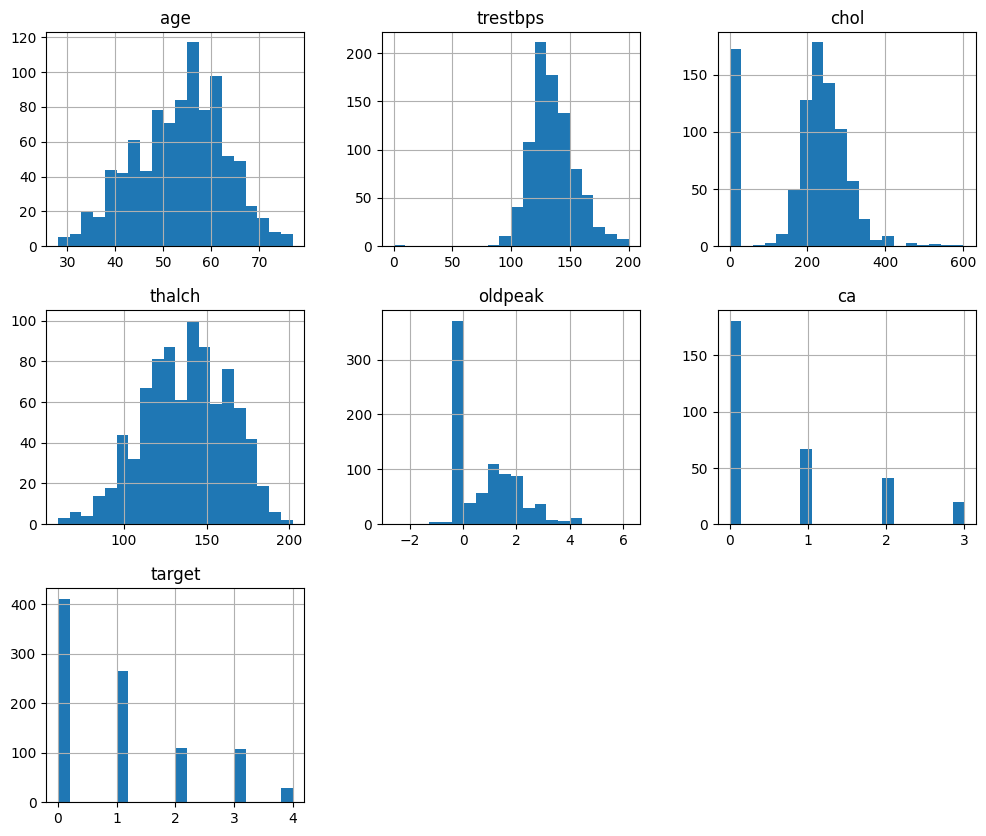

In [12]:
hist = data.hist(bins = 20, figsize = (12, 10))

In [13]:
print(data["sex"].unique())
print(data["cp"].unique())
print(data["fbs"].unique())
print(data["restecg"].unique())
print(data["exang"].unique())
print(data["slope"].unique())
print(data["thal"].unique())
print(data["target"].unique())

['Male' 'Female']
['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
[True False nan]
['lv hypertrophy' 'normal' 'st-t abnormality' nan]
[False True nan]
['downsloping' 'flat' 'upsloping' nan]
['fixed defect' 'normal' 'reversable defect' nan]
[0 2 1 3 4]


Categorical features in the data have some columns in the data containing unsupported values;

- cp: chest pain type, has four possible outcomes.
- sex: male or female.
- fbs: fasting blood sugar, 1 if greater than 120 mg/dl, 0 if false.
- restecg: resting electrocardiographic results, three possible values.
- exang: exercise induced angina, 1 for yes 0 for no.
- slope: the slope of the peak excercise ST segment, three possible outcomes
- thal: three possible outcomes, 1 normal, 2 fixed defect and 0 reversible defect.
- target: 1 has disease, 0 doesn't.

In [14]:
# revisit this if model performs poorly

restecg = data['restecg'].mode()
data['restecg'].fillna(restecg, inplace = True)

mean = data['trestbps'].mean(skipna = True)
median = data['trestbps'].median(skipna = True)
avg = (mean + median) / 2
data['trestbps'].fillna(avg, inplace = True)

mean = data['chol'].mean(skipna = True)
median = data['chol'].median(skipna = True)
avg = (mean + median) / 2
data['chol'].fillna(avg, inplace = True)

mean = data['thalch'].mean(skipna = True)
median = data['thalch'].median(skipna = True)
avg = (mean + median) / 2
data['thalch'].fillna(avg, inplace = True)

mean = data['oldpeak'].mean(skipna = True)
median = data['oldpeak'].median(skipna = True)
avg = (mean + median) / 2
data['oldpeak'].fillna(avg, inplace = True)



#chol = data['chol'].

#thalch = data['thalch'].

#oldpeak = data['oldpeak'].
# Mean or median imputation for trestbps, chol, thalch, oldpeak

In [15]:
data.dropna(inplace = True)

In [16]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [17]:
data.shape

(299, 14)

In [18]:
data = data.loc[(data['target'] == 0) | (data['target'] == 1)]

In [19]:
lab_enc = LabelEncoder()
data['sex'] = lab_enc.fit_transform(data['sex'])
data['cp'] = lab_enc.fit_transform(data['cp'])
data['fbs'] = lab_enc.fit_transform(data['fbs'])
data['restecg'] = lab_enc.fit_transform(data['restecg'])
data['exang'] = lab_enc.fit_transform(data['exang'])
data['slope'] = lab_enc.fit_transform(data['slope'])
data['thal'] = lab_enc.fit_transform(data['thal'])

print(data["sex"].unique())
print(data["cp"].unique())
print(data["fbs"].unique())
print(data["restecg"].unique())
print(data["exang"].unique())
print(data["slope"].unique())
print(data["thal"].unique())
print(data["target"].unique())

data.head(1)

[1 0]
[3 0 2 1]
[1 0]
[0 1 2]
[0 1]
[0 1 2]
[0 2 1]
[0 1]


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0


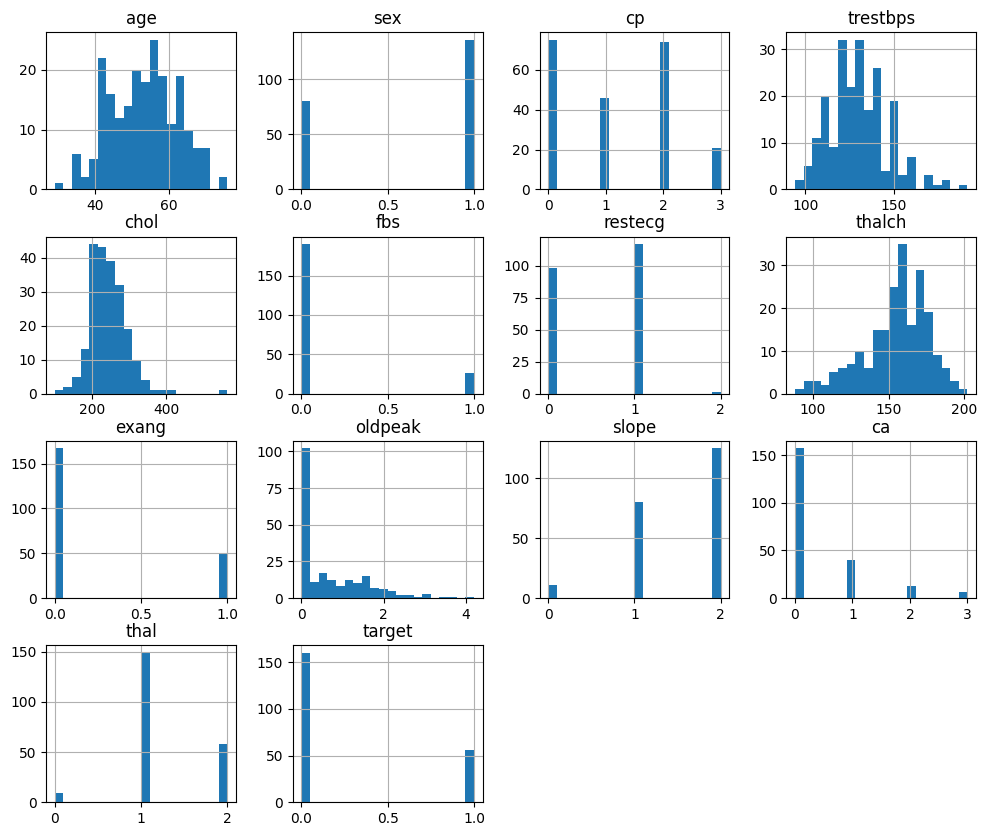

In [20]:
# Histogram of features

hist = data.hist(bins = 20, figsize = (12, 10))

Highest age:  76 Lowest age:  29


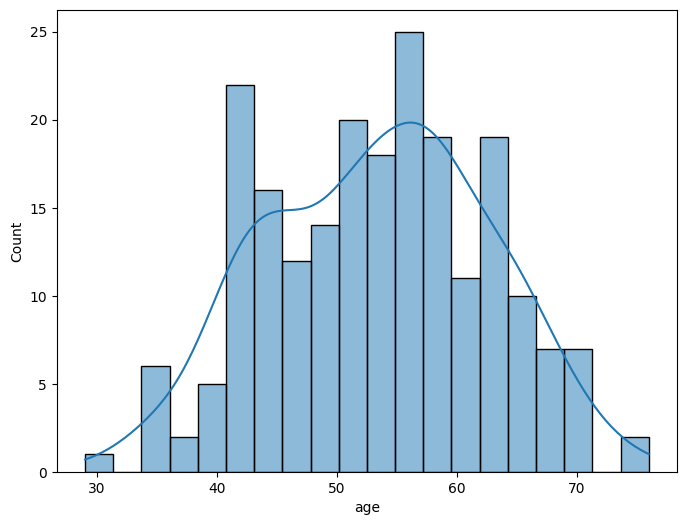

In [21]:
# Age distribution

plt.figure(figsize = (8, 6))
sbn.histplot(data['age'], kde = True, bins = 20)
print("Highest age: ", data['age'].max(), "Lowest age: ", data['age'].min())

In [22]:
cp_ranges = {
    'Type 0': ['Type 0', 0],
    'Type 1': ['Type 1', 1],
    'Type 2': ['Type 2', 2],
    'Type 3': ['Type 3', 3]
}

chest_pain = data.groupby(pd.cut(data['cp'], 
                                bins = [-float('inf')]+[i[1] for i in cp_ranges.values()], 
                                labels = cp_ranges.keys())).size().to_dict()

colors = {'Type 0': '#afafaf',
          'Type 1': '#666666',
          'Type 2': '#333333',
          'Type 3': '#000000'}

fig = go.Figure(data=[go.Pie(labels=list(chest_pain.keys()), values=list(chest_pain.values()),
                             marker=dict(colors=list(colors.values())))])
fig.update_layout(title='Chest Pain', showlegend = True)
fig.show()

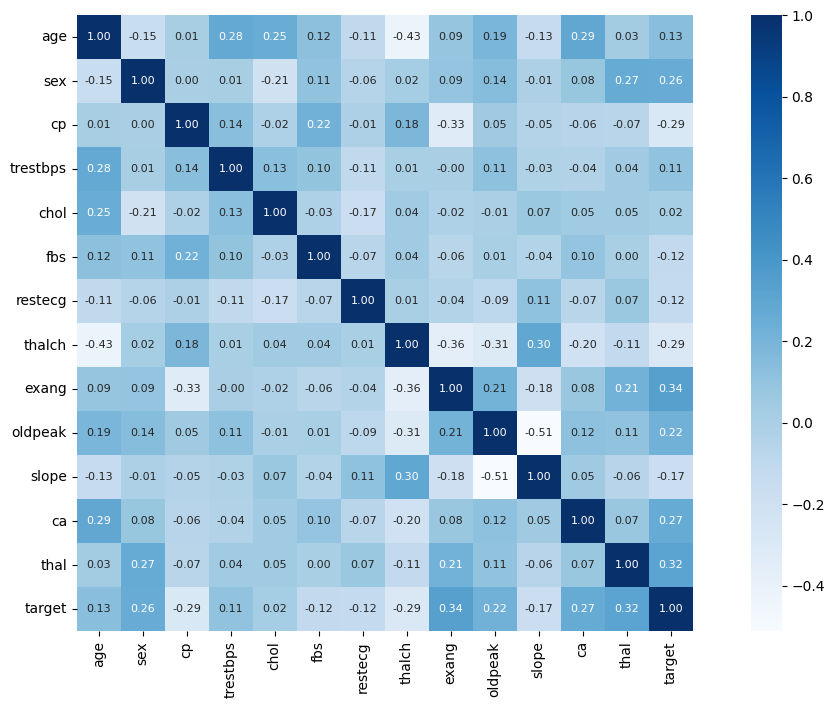

In [23]:
# Feature Correlation

corrmat = data.corr()

plt.figure(figsize=(15, 8))

hm = sbn.heatmap(corrmat,
                 cbar = True,
                 annot = True,
                 square = True,
                 fmt = '.2f',
                 annot_kws = {'size': 8}, 
                 yticklabels = data.columns, 
                 xticklabels = data.columns, 
                 cmap = "Blues"                 
                 )

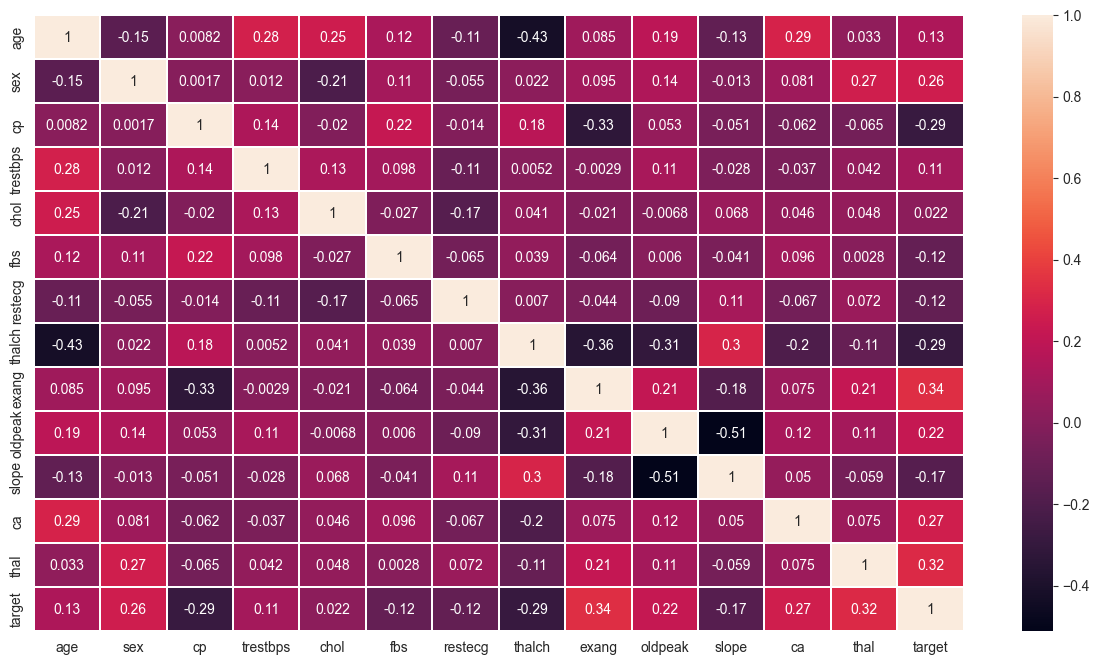

In [24]:
sbn.set_style('whitegrid')
plt.figure(figsize = (15, 8))
sbn.heatmap(data.corr(), annot = True, linewidths = .3)
plt.show()

Text(0.5, 1.0, 'Target Counts')

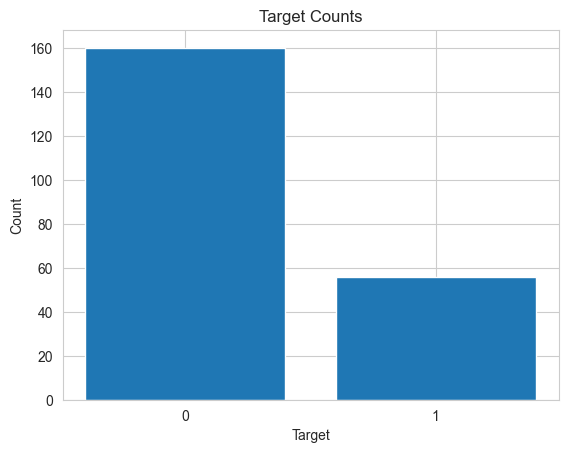

In [25]:
plt.bar(data['target'].unique(), data['target'].value_counts())
plt.xticks([0, 1])
plt.xlabel("Target")
plt.ylabel("Count")
plt.title("Target Counts")

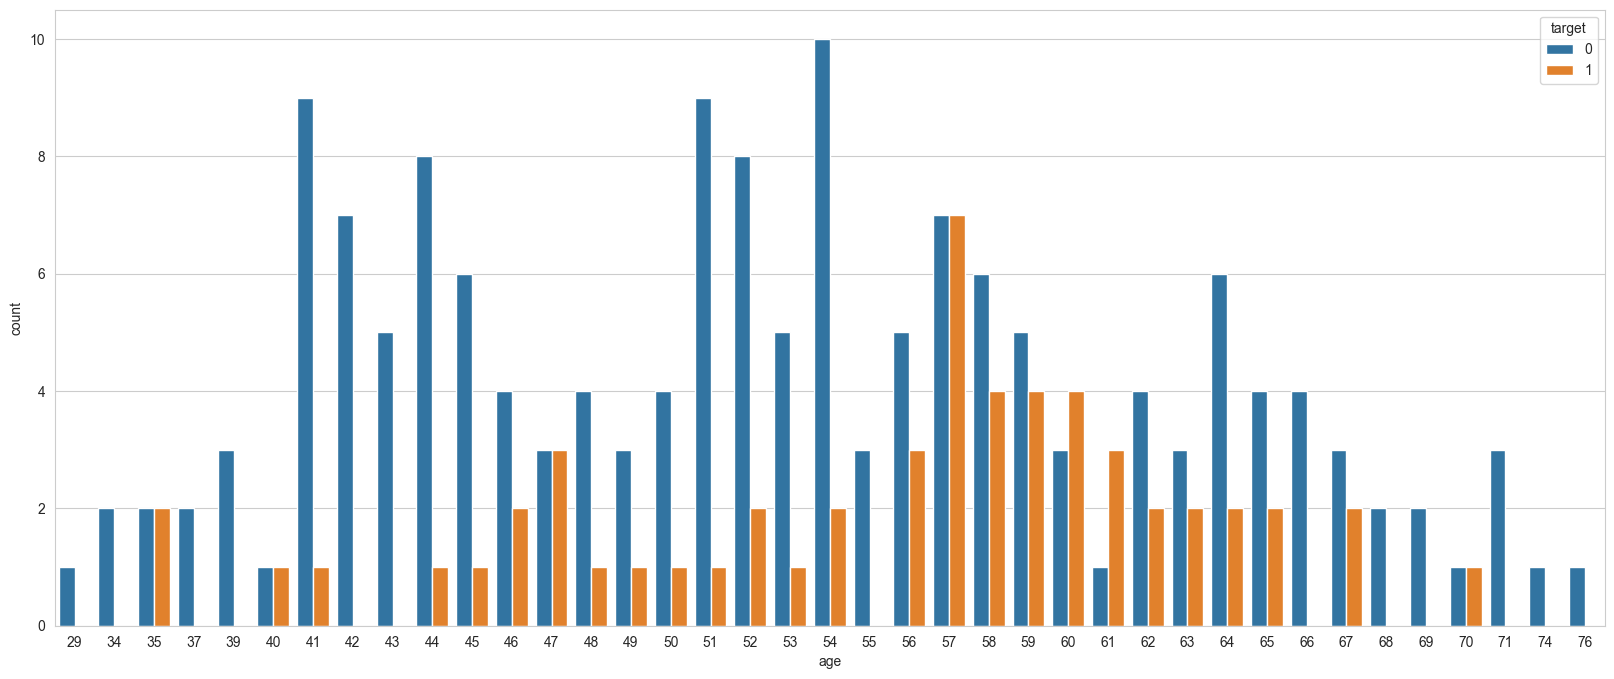

In [26]:
plt.figure(figsize = (20, 8))
sbn.countplot(x = 'age', data = data, hue = 'target')
plt.show()

In [27]:
# Feature and Target selection

X = data.drop('target', axis = 1)
Y = data['target']
print(X.shape)
print(Y.shape)

(216, 13)
(216,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 69, shuffle = True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

print(X_train.shape, y_train.shape)

(162, 13) (162,)


In [29]:
# Define the XGBClassifier xgb_class
xgb_class = XGBClassifier() # max_depth = 7, n_estimators = 100)

# Fit the xgb_class to the training data
xgb_class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [30]:
y_pred = xgb_class.predict(X_test)

In [31]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("XGBClassifier accuracy: %.2f%% " % (accuracy * 100))

# Compute the feature importance
feature_importances = xgb_class.feature_importances_ * 100
print("Feature importances:")
print(feature_importances)

#correct this

XGBClassifier accuracy: 83.33% 
Feature importances:
[ 5.1809344  8.307842  10.590633   4.857942   4.410282   0.
  6.2020407  6.175711  28.277409   4.3666067  3.5393224 11.169168
  6.9221153]


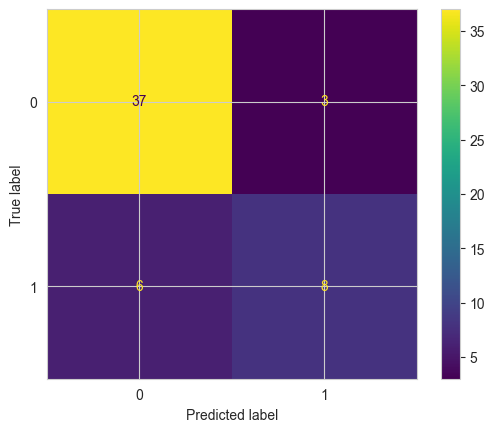

In [37]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

conf_mat = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)#, display_labels = ["Defaulted", "Did not default"])

conf_mat.plot()
plt.show()

In [38]:
# Identifying feature importance for modelling

plt.figure(figsize = (15, 7))
plt.bar([i for i in range(len(X.columns))], feat_scores, width = 0.6)
for i in range(len(X.columns)):
    plt.text(i, feat_scores[i], feat_scores[i])
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance")

NameError: name 'plf' is not defined

In [39]:
import keras
from keras import layers
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [40]:
# Reduce learning rate when no improvement in target metric
reducelr_on_plt = ReduceLROnPlateau(monitor = 'val_loss',
                                    factor = 0.1,
                                    patience = 10,
                                    verbose = 0,
                                    mode = 'auto', 
                                    min_delta = 0.0001,
                                    min_lr = 0.00001)

# Early stopping to reduce overfitting
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', 
                                       verbose = 0, 
                                       patience = 20, 
                                       baseline = 0.3)

best_trained_model_file = 'best_trained_model.h5'

# Saving model after epoch
checkpoint = ModelCheckpoint(best_trained_model_file, 
                             verbose = 0,
                             monitor = 'val_loss', 
                             save_best_only = True, 
                             mode = 'auto')

callbacks = [checkpoint, reducelr_on_plt]
#callbacks = [early_stopping_monitor]

In [41]:
# Defining model architecture

model = keras.Sequential([
    keras.Input(shape = (13)),
    layers.Dense(256, kernel_initializer = 'uniform', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(512, kernel_initializer = 'uniform', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(256, kernel_initializer = 'uniform', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer = 'uniform', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'),
])

In [42]:
# Compiling model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)

# Parameters summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [ ]:
'''
model = Sequential()
model.add(Dense(256, input_dim = 13, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(512, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(256, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
'''


In [43]:
# Mdel fitting
history = model.fit(
    X_train, y_train,
    validation_split = 0.25, 
    epochs = 40,
    batch_size = 64,
    callbacks = callbacks,
    verbose = 0
)

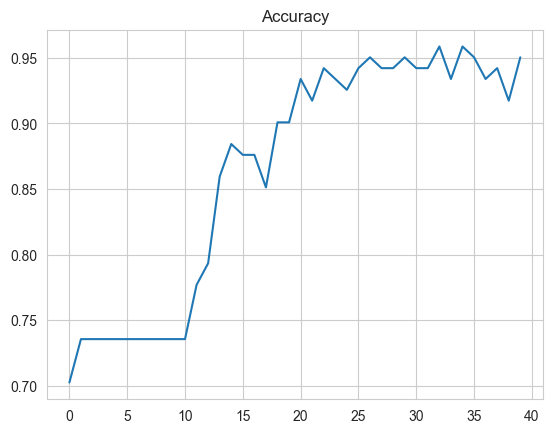

In [44]:
# Model accuracy plot
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.show()

<Axes: >

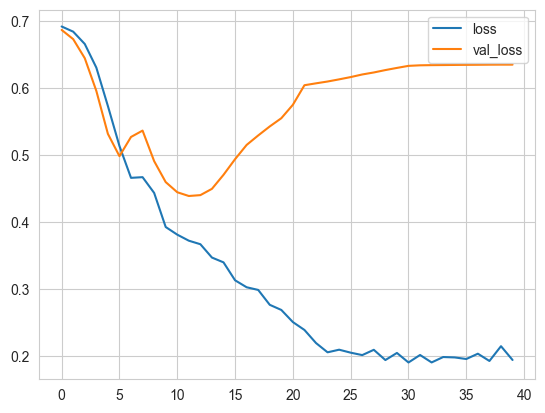

In [45]:
# Validation loss plot

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [46]:
# Evaluate model against seen and unseen data
train_score = model.evaluate(X_train, y_train, verbose = 0)
print("Evaluation score with training data: %.2f%%" % (train_score[1] * 100))

test_score = model.evaluate(X_test, y_test, verbose = 0)
print("Evaluation score with validating data: %.2f%%" % (test_score[1] * 100))



Evaluation score with training data: 93.21%
Evaluation score with validating data: 79.63%


In [47]:
# Visualising model actual and predicted class and probability
print("Model prediction testing")
y_pred_class = model.predict(X_test)
y_pred_class = np.argmax(y_pred_class, axis = -1)
y_pred_prob = model.predict(X_test)

print("Index Actual | Predicted | Probability")
for idx, label in enumerate(y_test):
    print("%s     | %s  | %s |   %.2f%%" % (str(idx), str(label), str(y_pred_class[idx]), float(y_pred_prob[idx])*100))
    
print("Accuracy Score: %.2f%%" % (accuracy_score(y_test, y_pred_class) * 100))

Model prediction testing
2/2 [==============================] - 0s 5ms/step
Index Actual | Predicted | Probability
0     | 0  | 0 |   59.57%
1     | 0  | 0 |   0.00%
2     | 1  | 0 |   62.19%
3     | 0  | 0 |   0.01%
4     | 0  | 0 |   0.00%
5     | 0  | 0 |   42.49%
6     | 0  | 0 |   0.00%
7     | 0  | 0 |   0.54%
8     | 0  | 0 |   0.00%
9     | 0  | 0 |   1.60%
10     | 0  | 0 |   0.33%
11     | 0  | 0 |   0.24%
12     | 1  | 0 |   66.12%
13     | 0  | 0 |   0.00%
14     | 0  | 0 |   15.95%
15     | 0  | 0 |   0.08%
16     | 0  | 0 |   0.04%
17     | 0  | 0 |   2.84%
18     | 0  | 0 |   45.77%
19     | 1  | 0 |   60.15%
20     | 0  | 0 |   0.37%
21     | 0  | 0 |   0.00%
22     | 0  | 0 |   60.68%
23     | 1  | 0 |   61.42%
24     | 0  | 0 |   0.17%
25     | 0  | 0 |   6.13%
26     | 0  | 0 |   0.02%
27     | 1  | 0 |   12.04%
28     | 0  | 0 |   0.00%
29     | 1  | 0 |   0.13%
30     | 0  | 0 |   0.00%
31     | 0  | 0 |   1.16%
32     | 1  | 0 |   65.18%
33     | 0  | 0 |   57.99%

C:\Users\dell\AppData\Local\Temp\ipykernel_10812\582979684.py:9: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



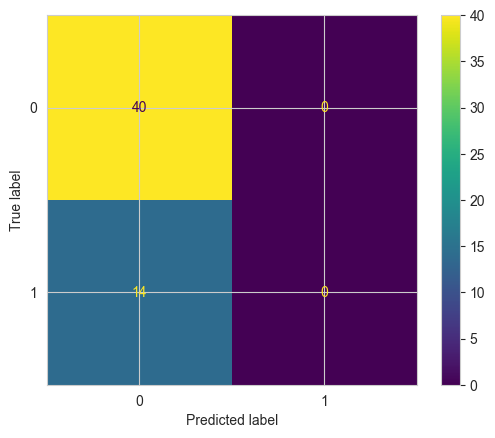

In [48]:
# Confusion matrix
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_class)

conf_mat = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)#, display_labels = ["Defaulted", "Did not default"])

conf_mat.plot()
plt.show()

In [49]:
#print(" ")
#count = len(["ok" for idx, label in enumerate(y_test) if label == y_pred_class[idx]])
#print("Accuracy rate: %.2f%%" % ((float(count) / len(y_test)) * 100))